In [ ]:
# DaTscan Analysis for Parkinson's Disease
# Copyright (C) 2025 Woolier Brooks
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [ ]:
import pydicom
import os

base_dir = "/dir"

for patient_num in range(1, 6):
    patient_folder = f"Paciente {patient_num}"
    patient_path = os.path.join(base_dir, patient_folder)
    
    print(f"\nAnalisando {patient_folder}:")
    
    for series_num in range(1, 9): 
        series_folder = f"series{series_num}"
        file_path = os.path.join(patient_path, series_folder, "Trodat1.dcm")
        
        try:
            dcm = pydicom.dcmread(file_path)
            volume_3d = dcm.pixel_array
            print(f"  Dimensões do volume na {series_folder}: {volume_3d.shape}")
        except FileNotFoundError:
            print(f"  Erro: Arquivo Trodat1.dcm não encontrado em {file_path}")

print("\nAnálise concluída para todos os pacientes.")


Analisando Paciente 1:
  Dimensões do volume na series1: (128, 128, 128)
  Dimensões do volume na series2: (23, 128, 128)
  Dimensões do volume na series3: (128, 128, 128)
  Dimensões do volume na series4: (38, 128, 128)
  Dimensões do volume na series5: (20, 128, 128)
  Dimensões do volume na series6: (16, 128, 128)
  Dimensões do volume na series7: (16, 128, 128)
  Dimensões do volume na series8: (32, 128, 128)

Analisando Paciente 2:
  Dimensões do volume na series1: (128, 128, 128)
  Dimensões do volume na series2: (128, 128, 128)
  Dimensões do volume na series3: (16, 128, 128)
  Dimensões do volume na series4: (33, 128, 128)
  Dimensões do volume na series5: (26, 128, 128)
  Dimensões do volume na series6: (21, 128, 128)
  Dimensões do volume na series7: (18, 128, 128)
  Dimensões do volume na series8: (16, 128, 128)

Analisando Paciente 3:
  Dimensões do volume na series1: (128, 128, 128)
  Dimensões do volume na series2: (18, 128, 128)
  Dimensões do volume na series3: (128, 1

[get_dataset_dir] Dataset found in C:\Users\Lenovo\nilearn_data\fsl

[get_dataset_dir] Dataset found in C:\Users\Lenovo\nilearn_data\fsl

Dimensões do atlas cortical: (91, 109, 91)
Dimensões do atlas subcortical: (91, 109, 91)

Processando Paciente 1 (ID: 793573) - Dimensões originais do volume: (38, 128, 128)
Volume cortado para 32 fatias.


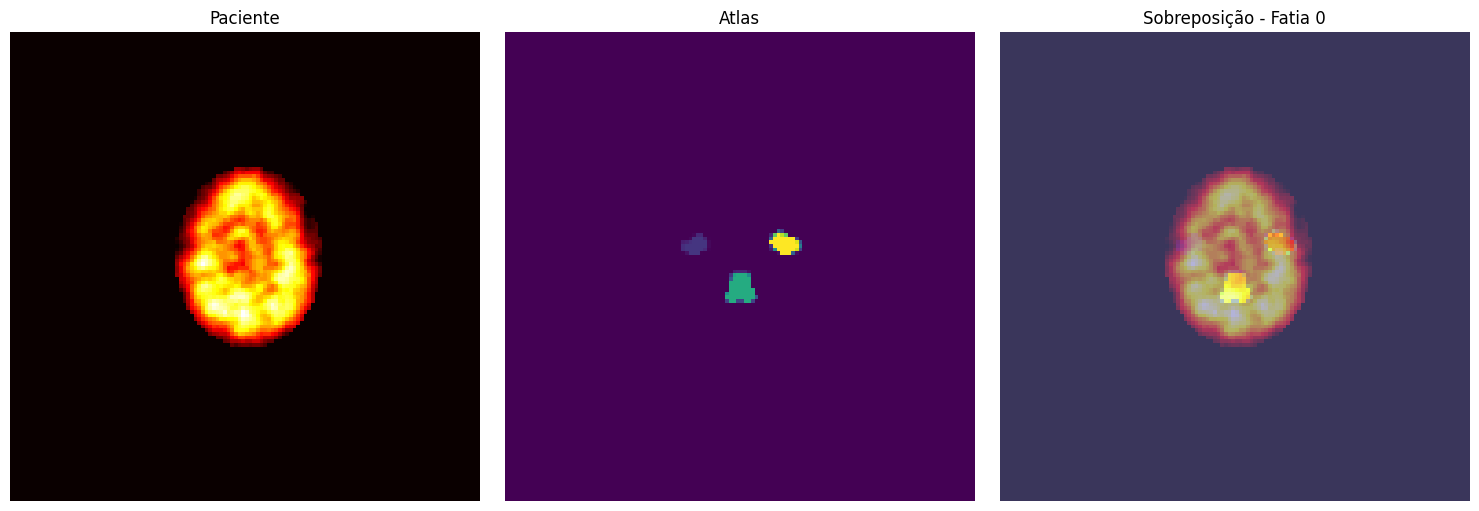

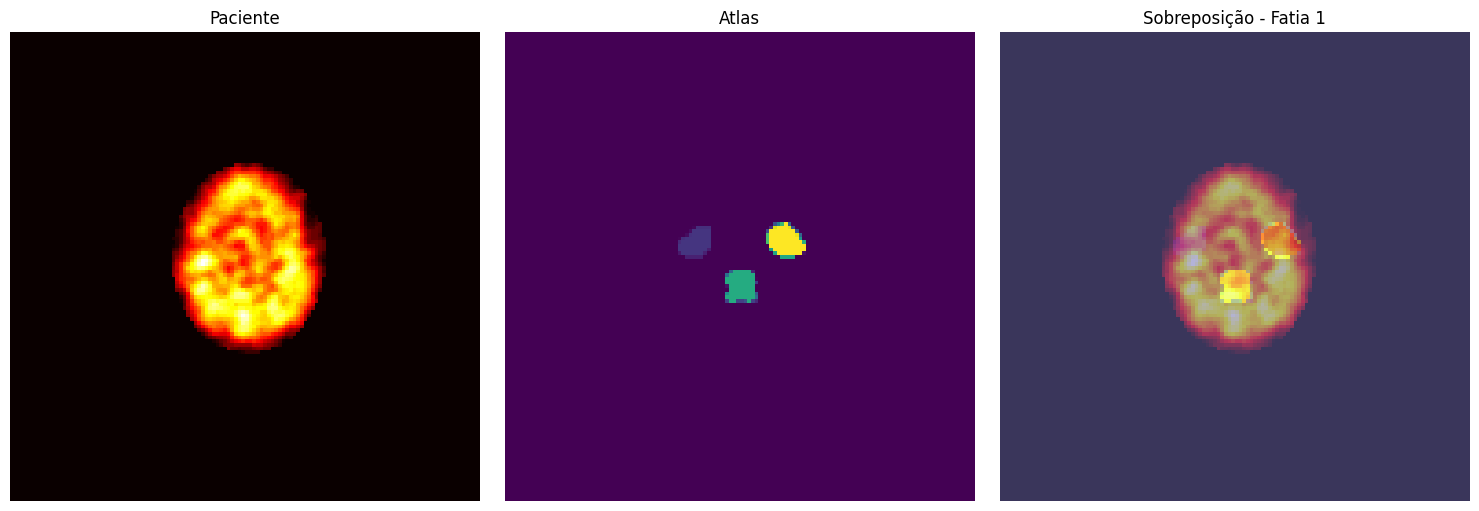

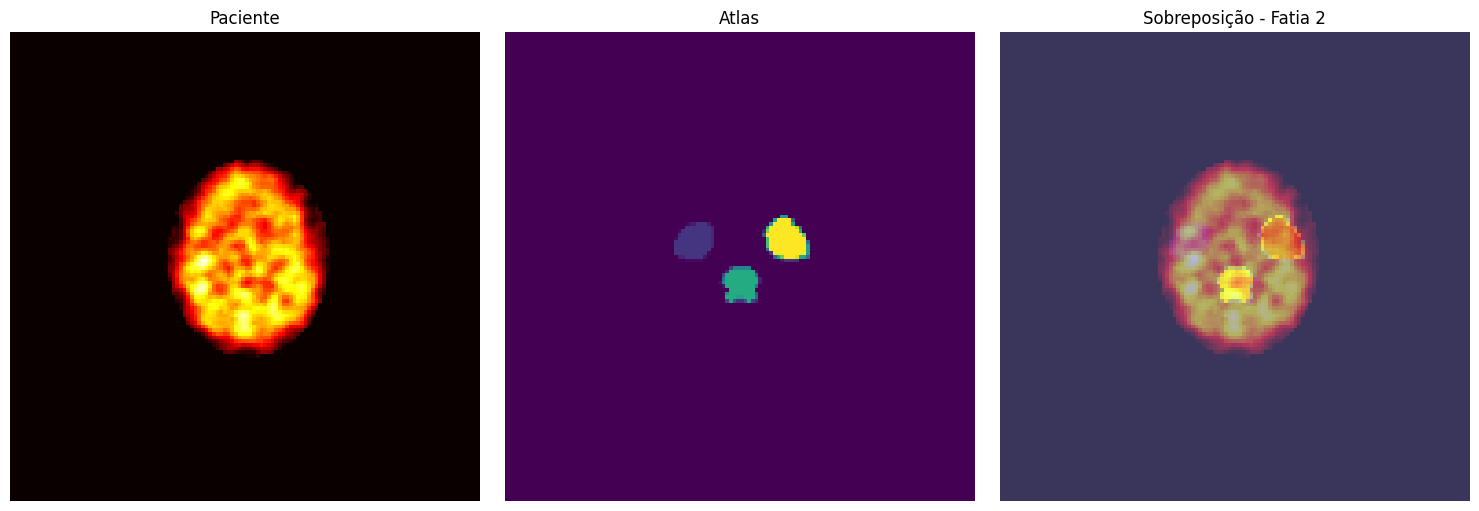

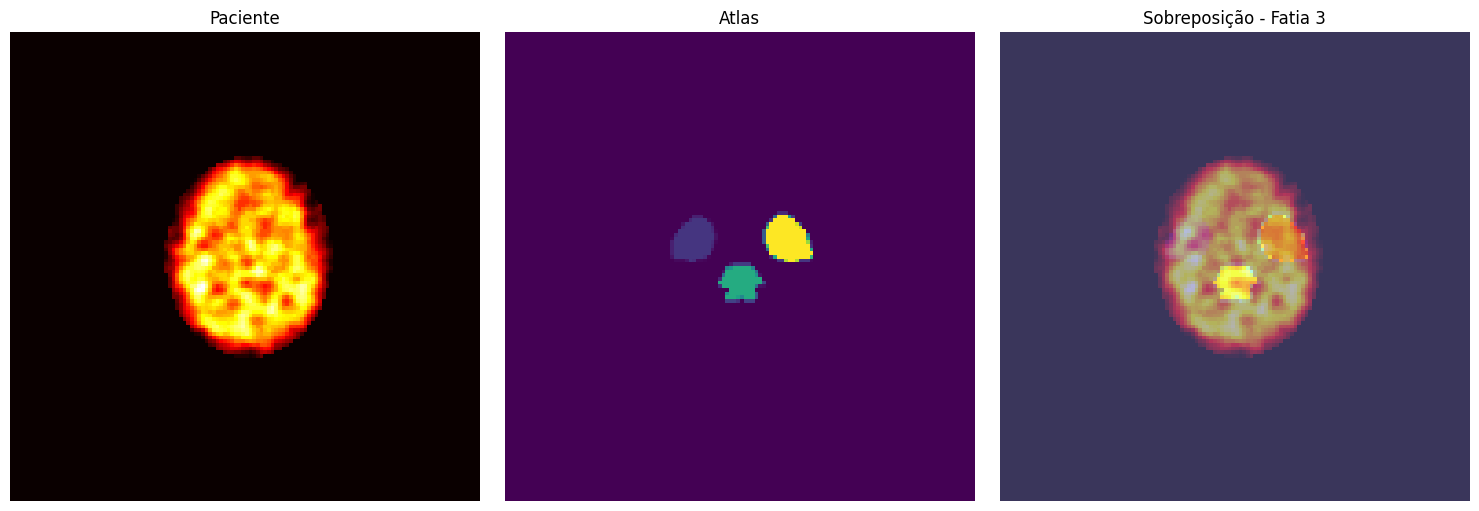

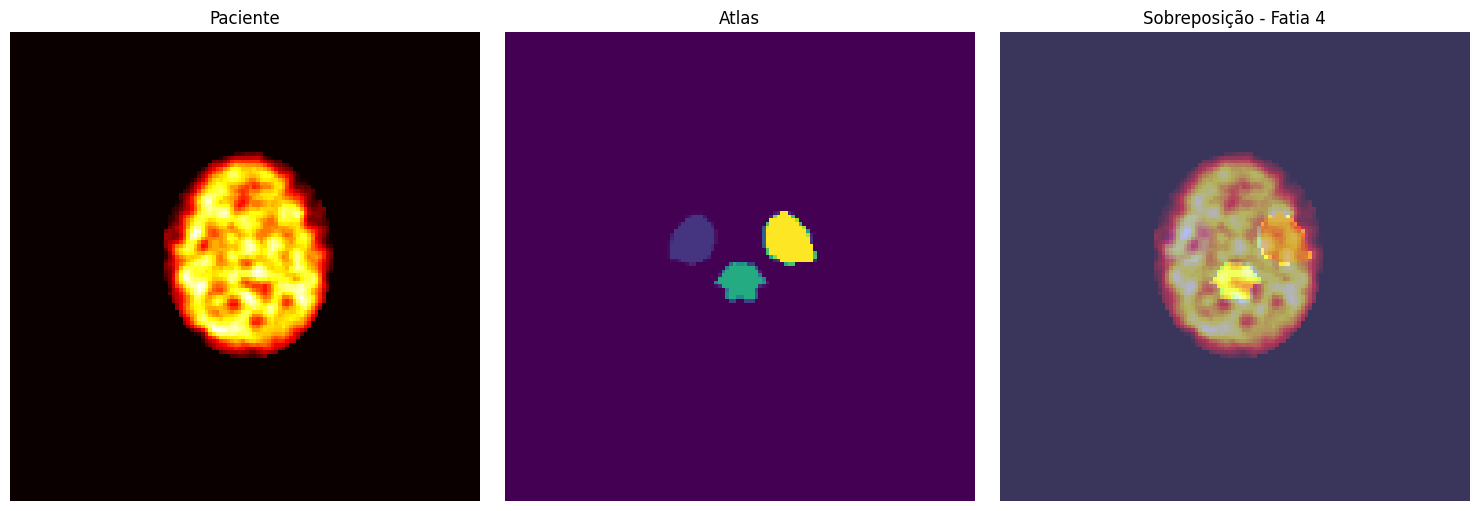

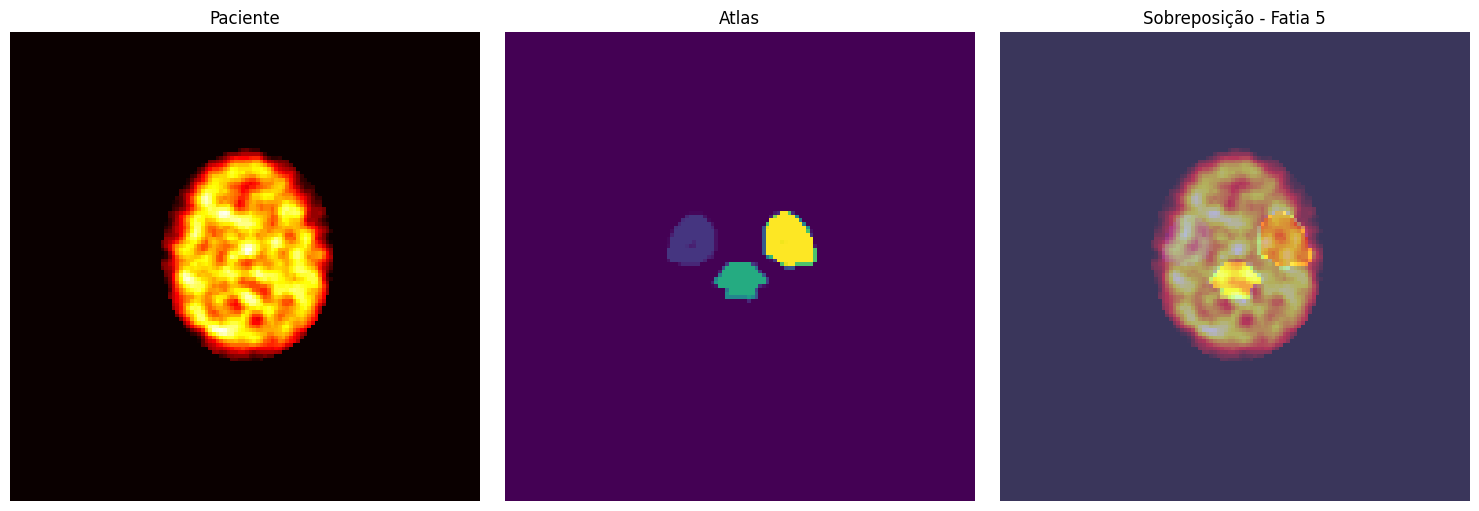

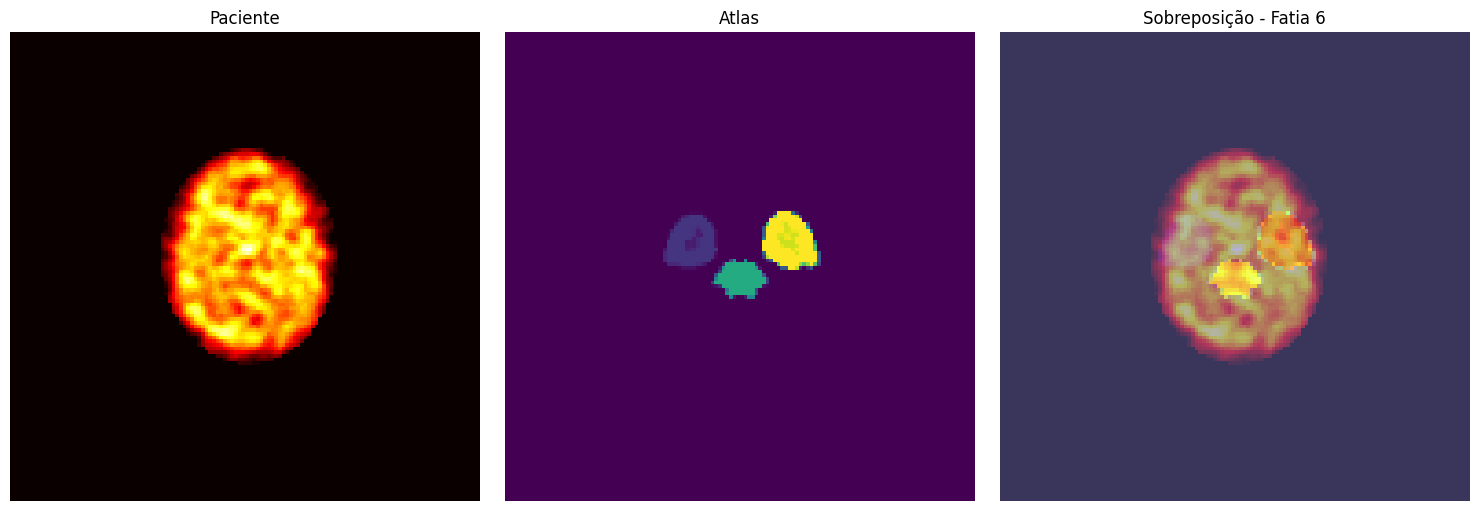

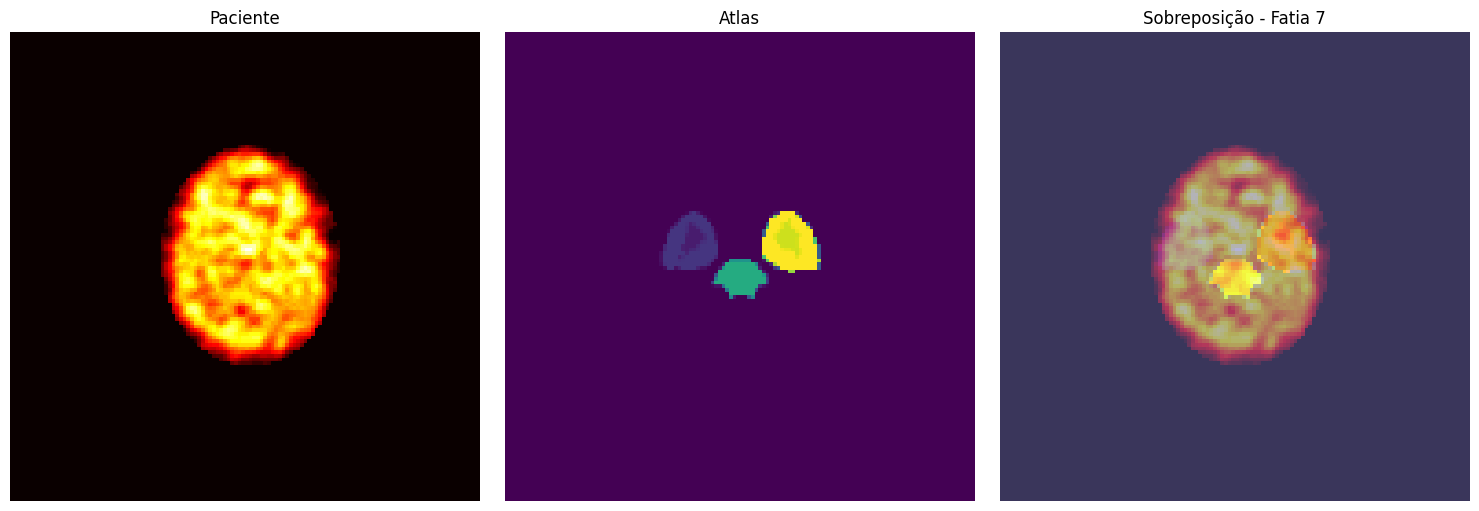

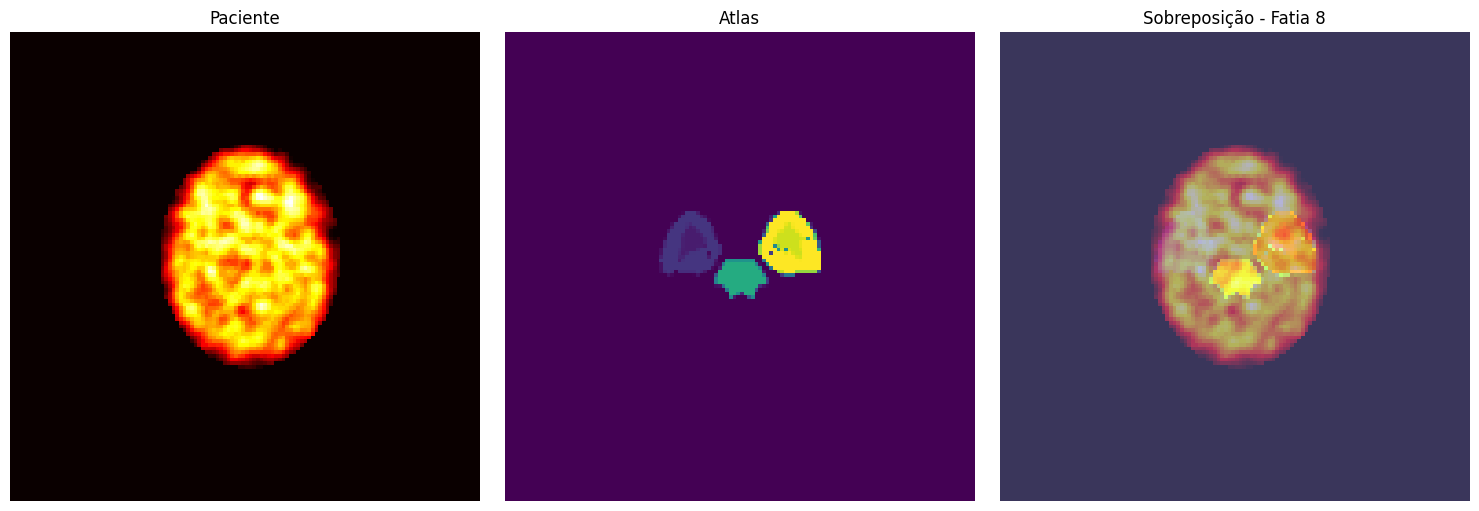

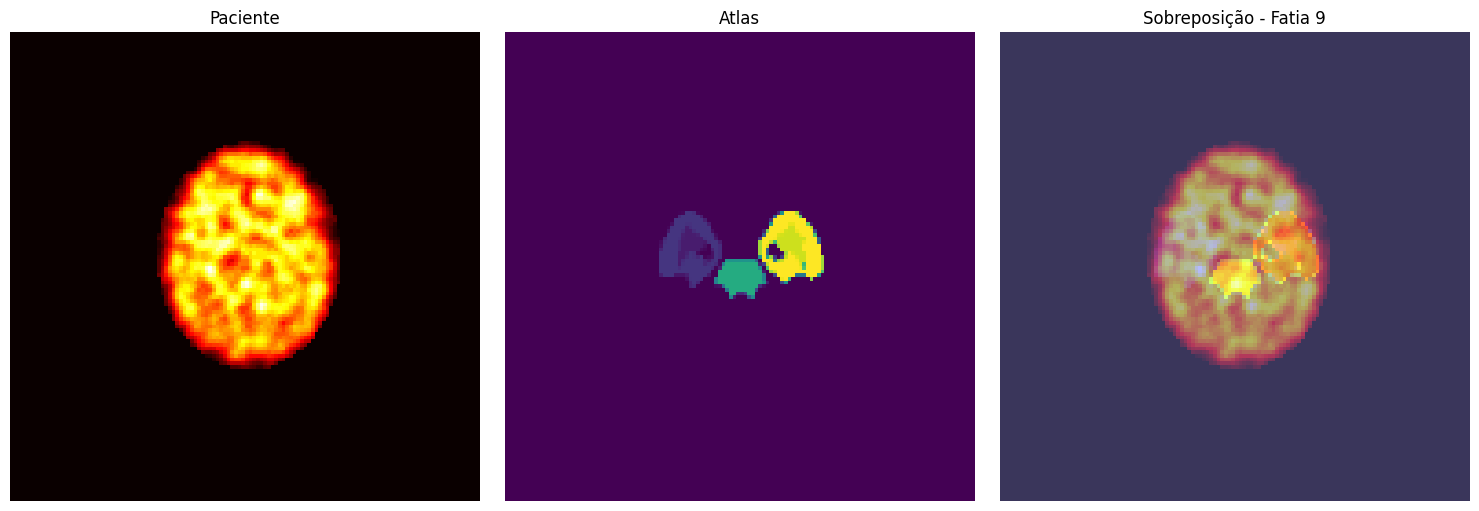

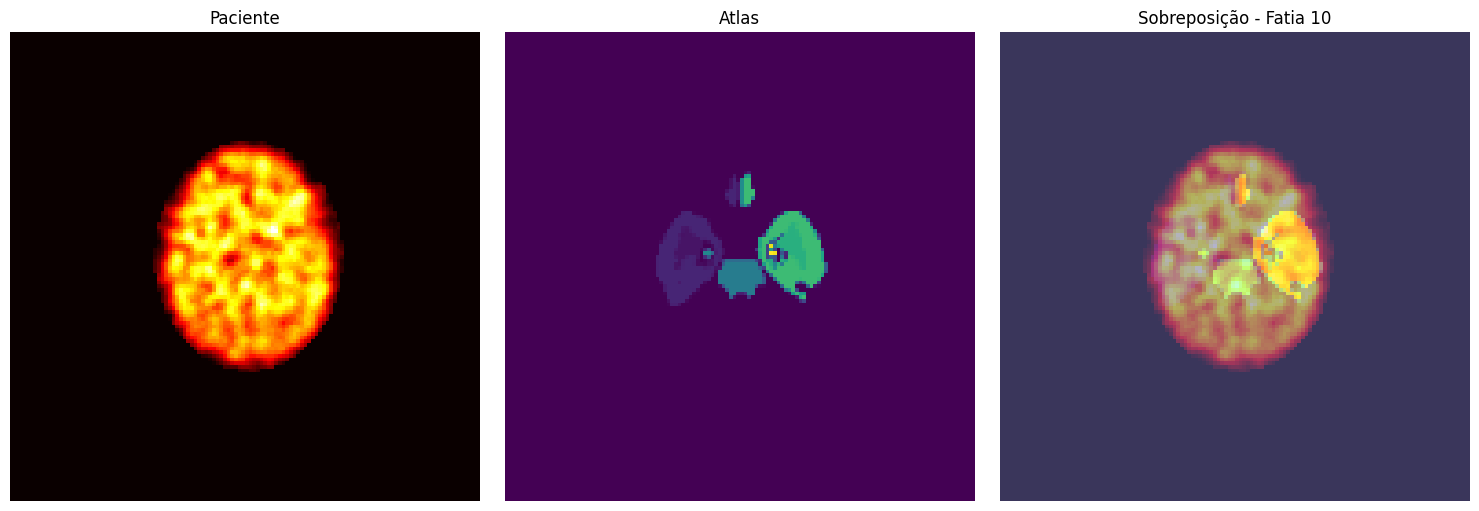

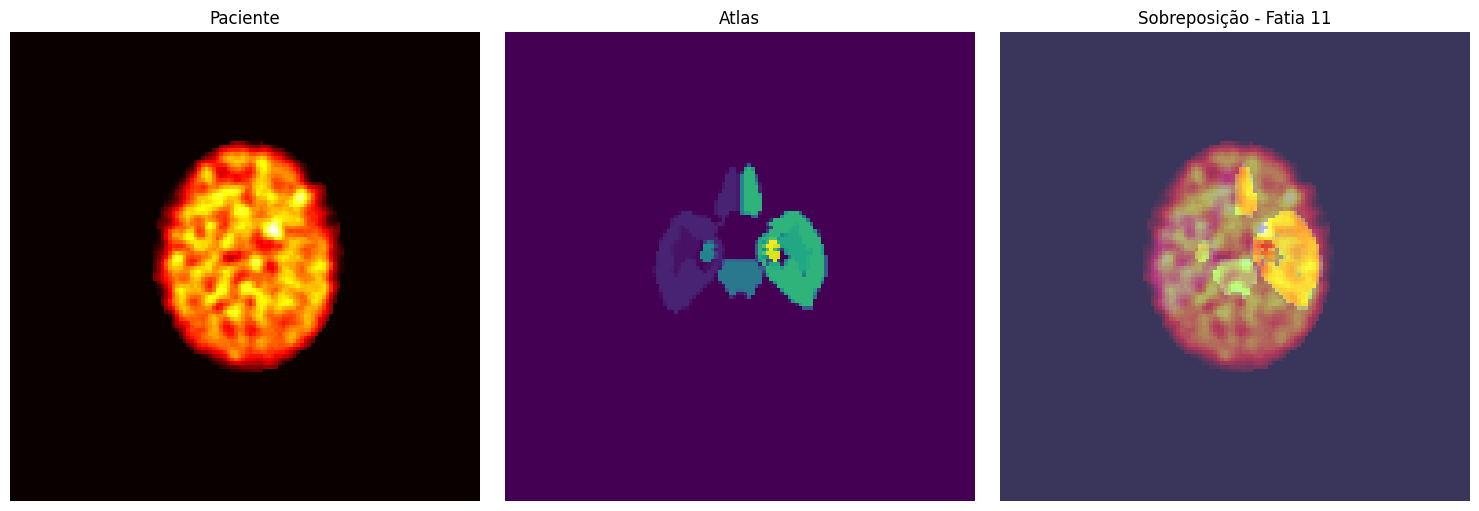

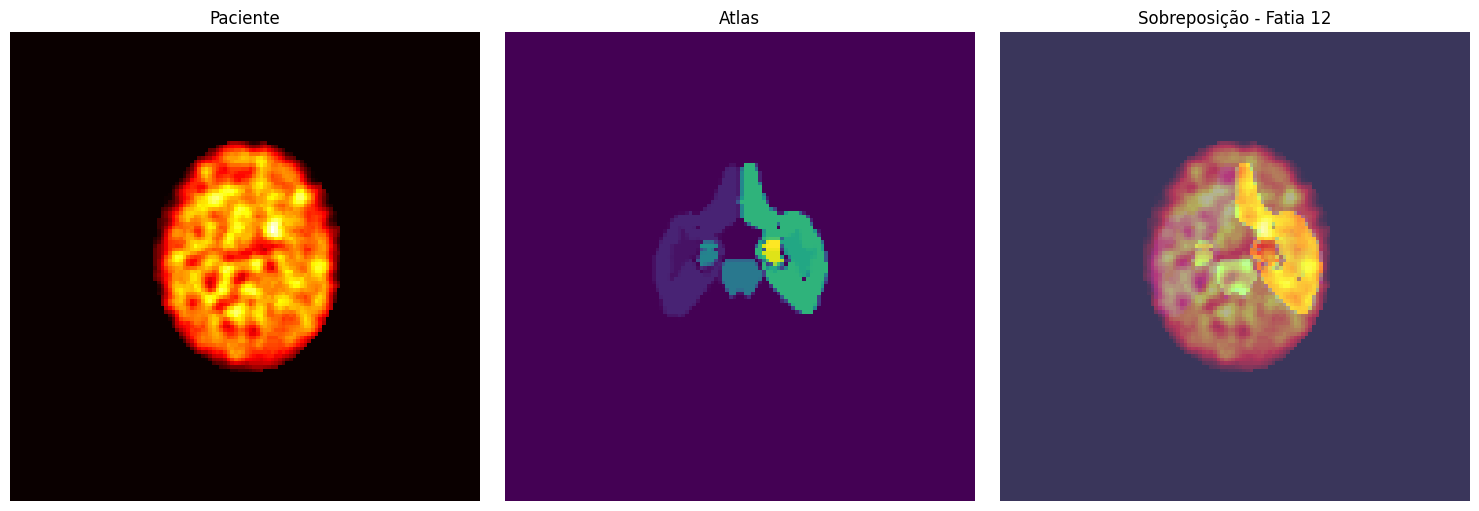

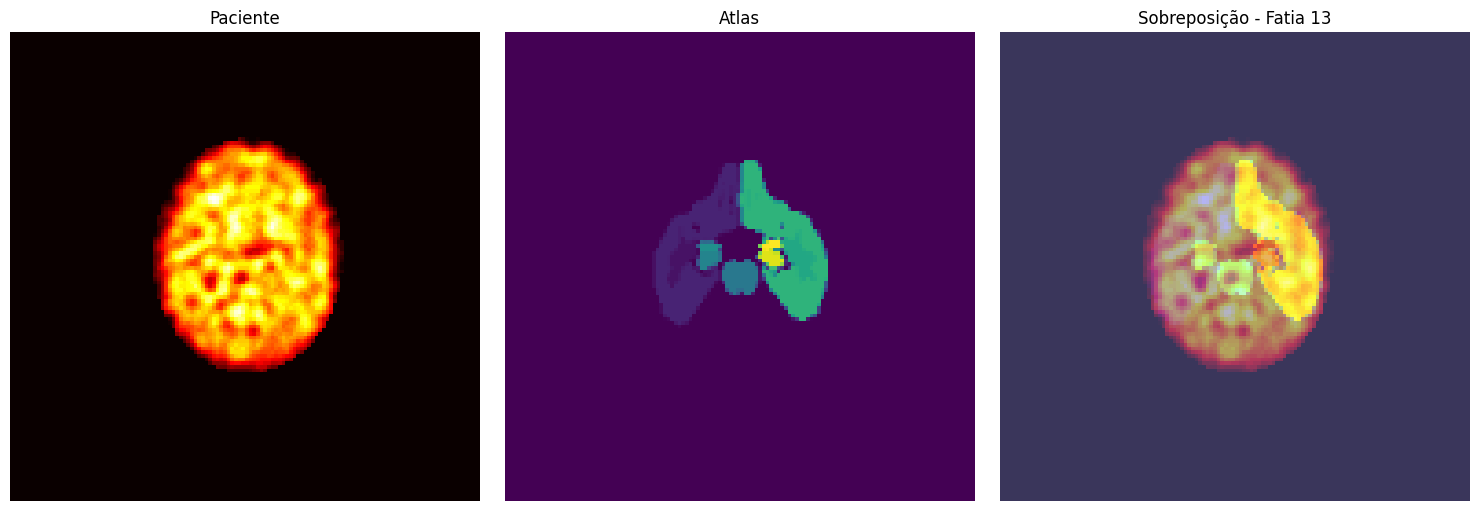

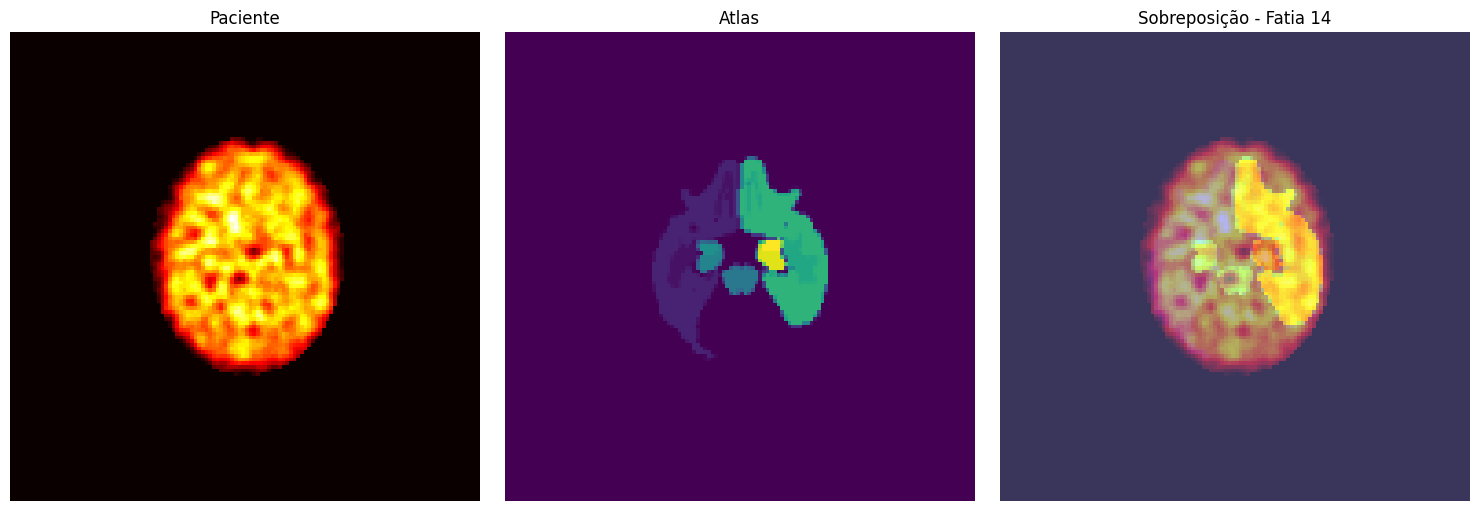

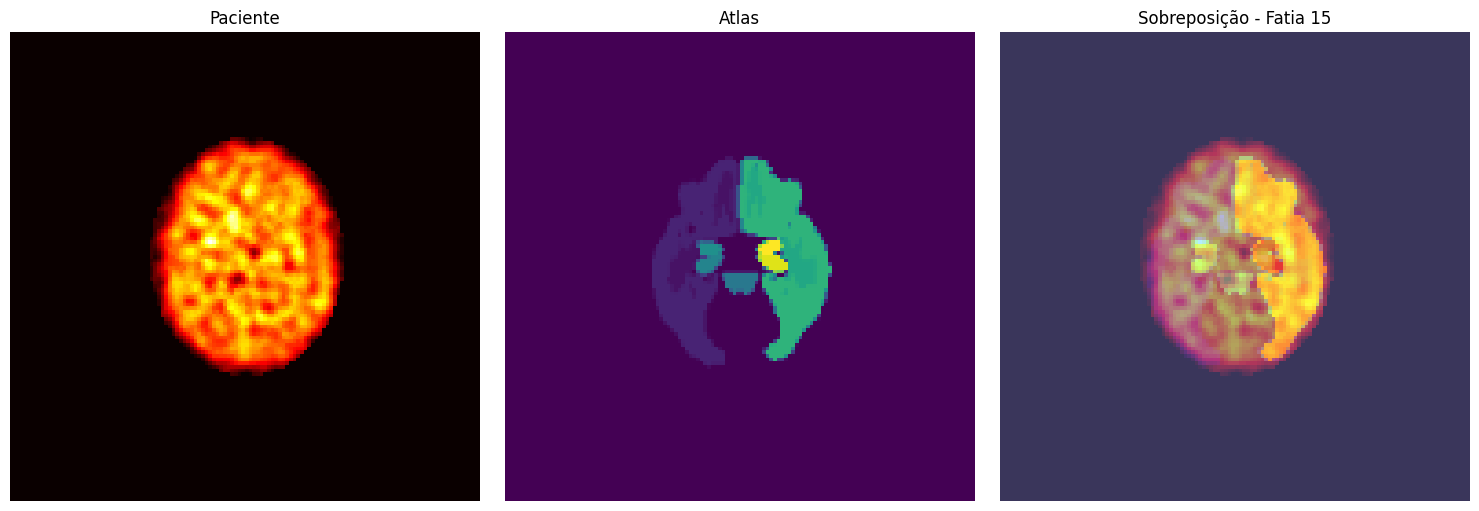

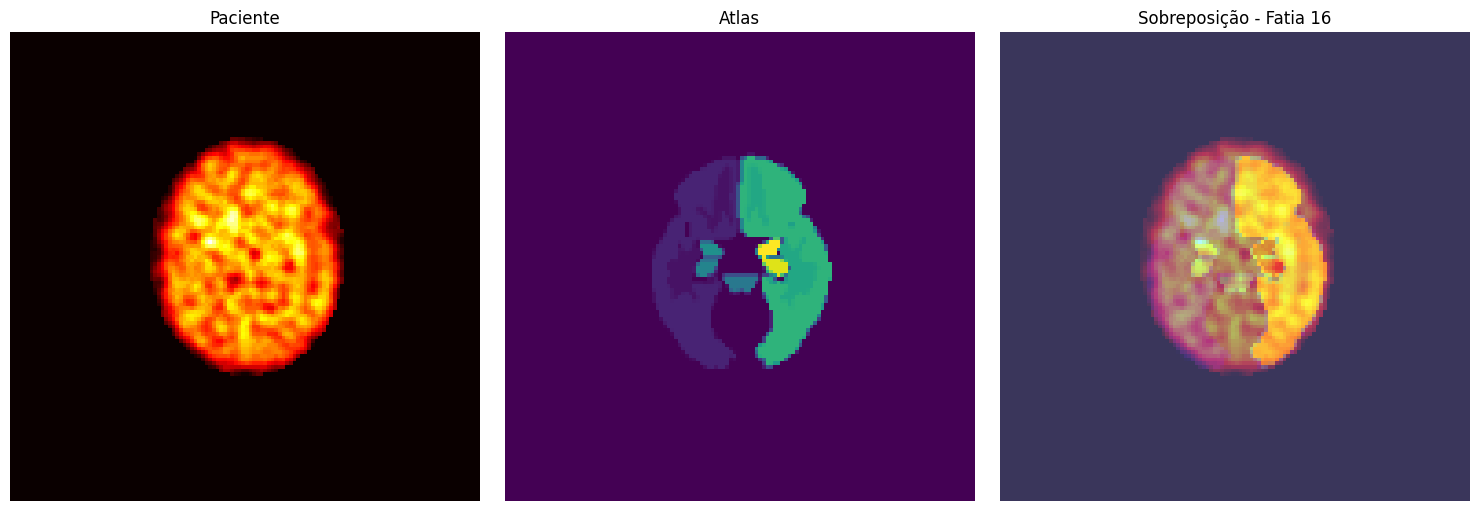

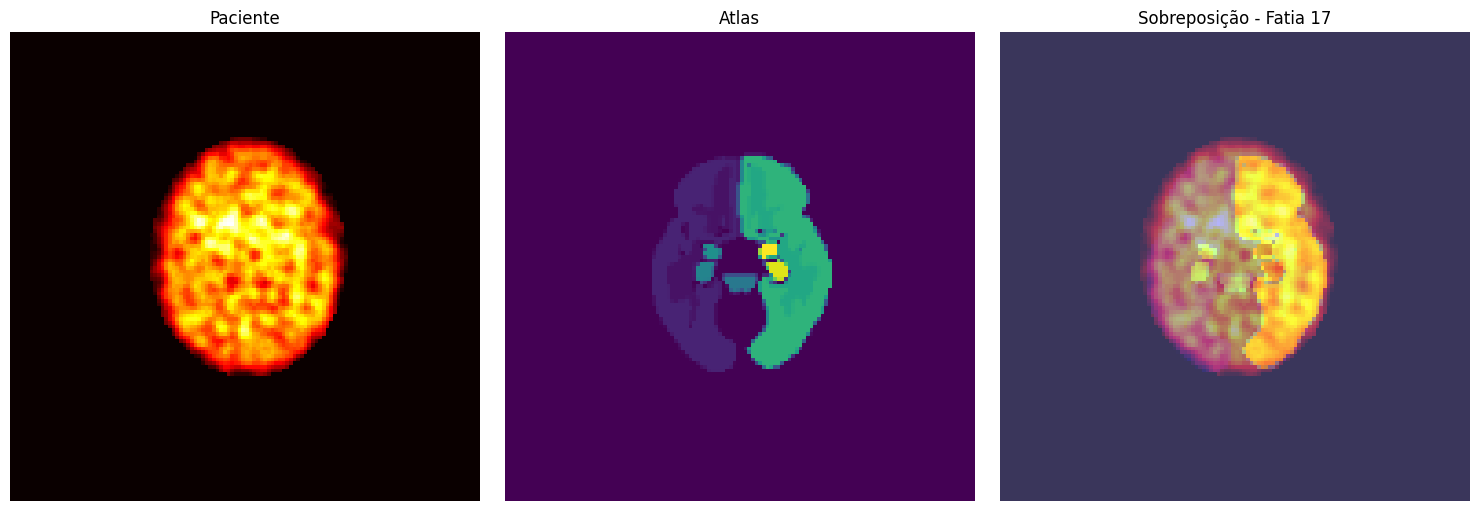

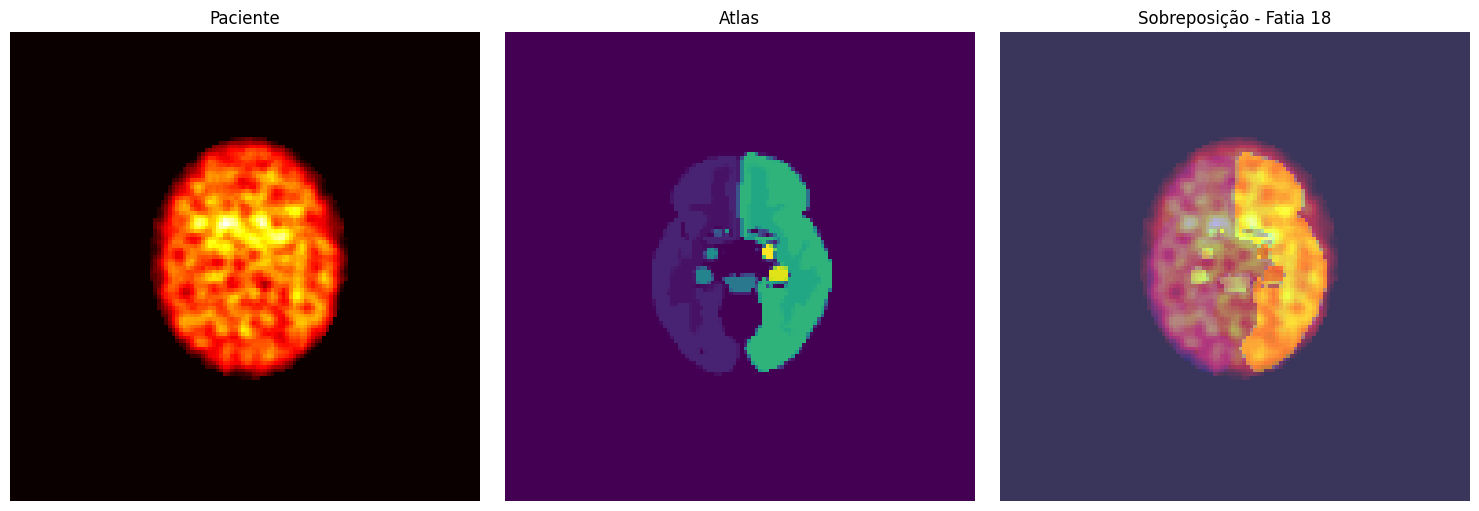

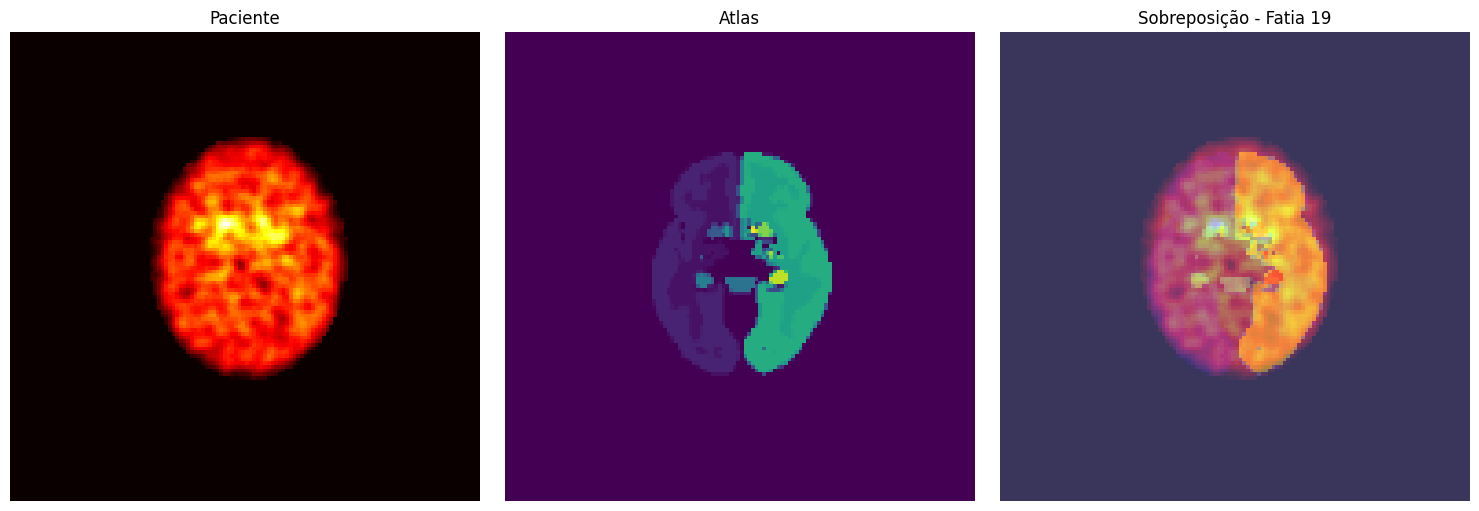

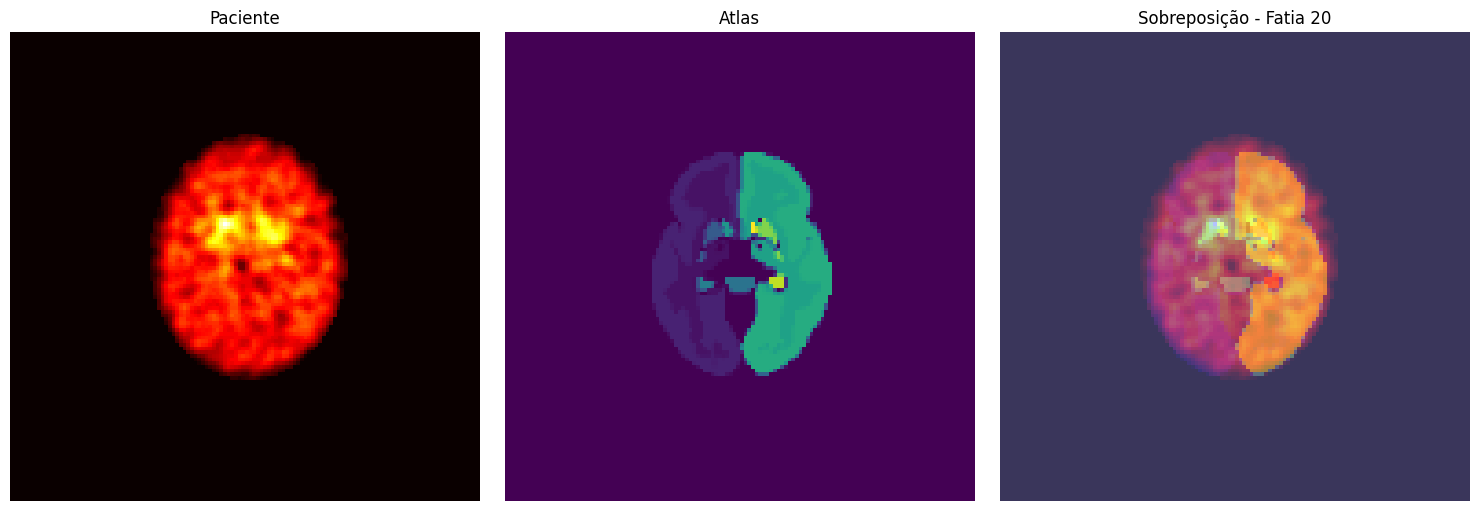

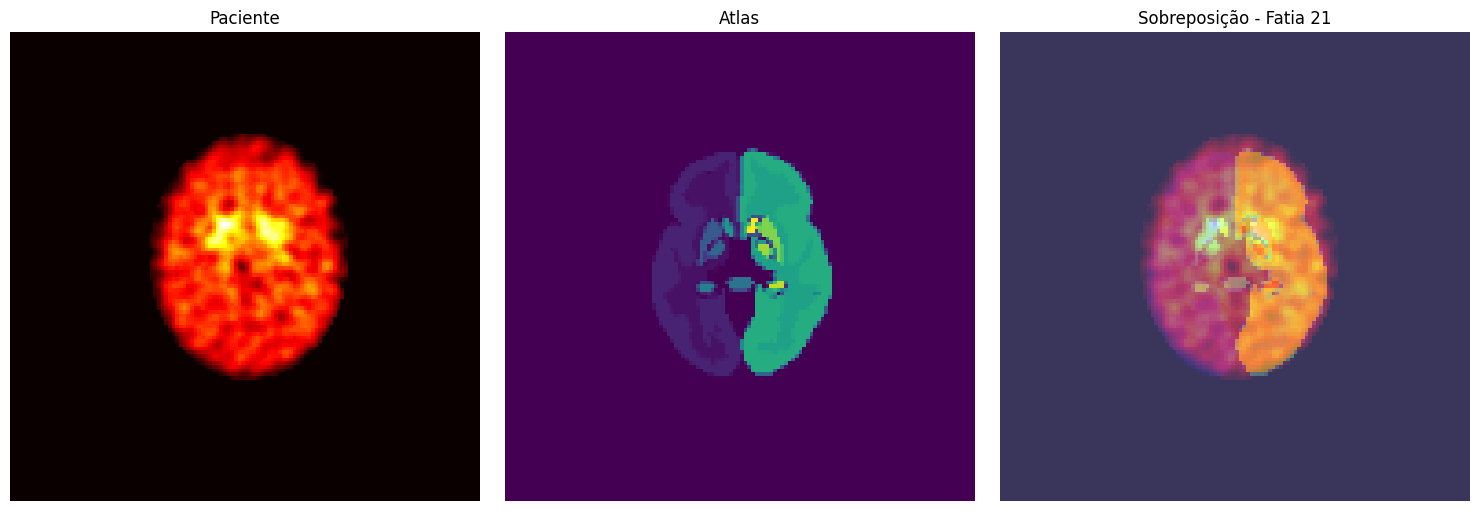

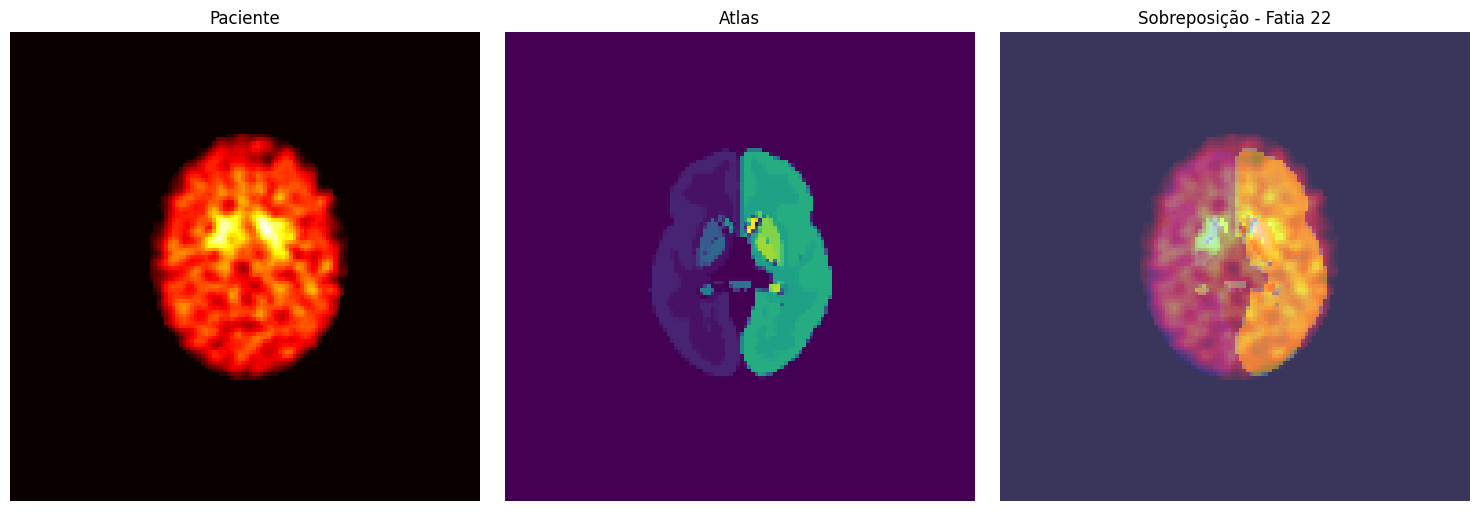

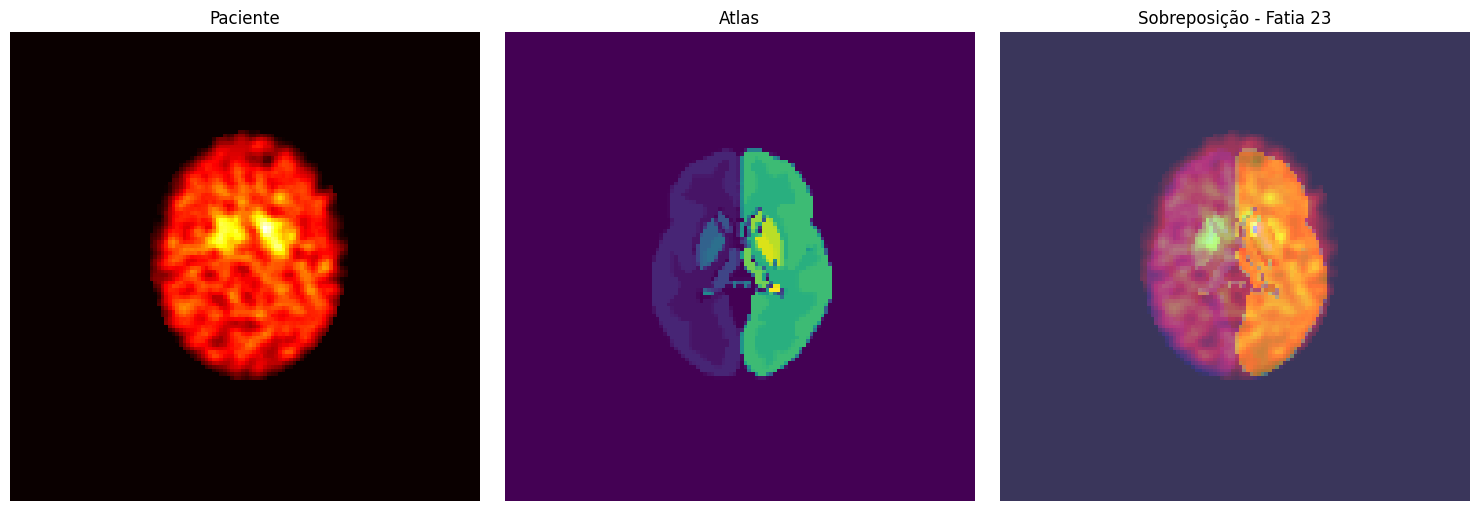

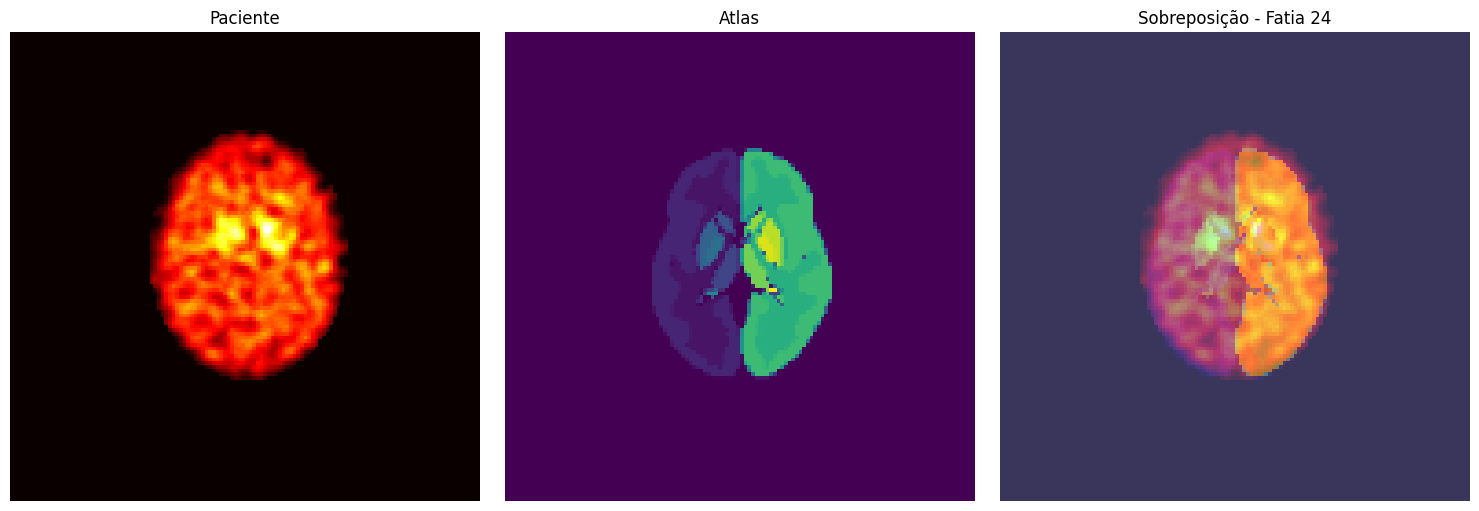

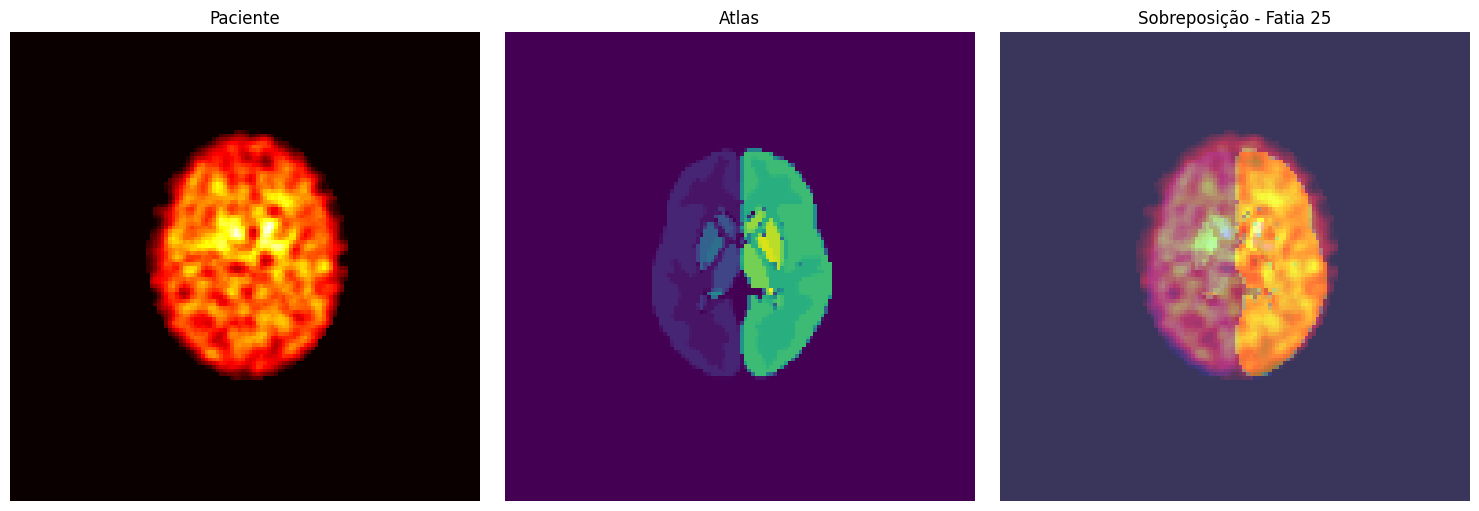

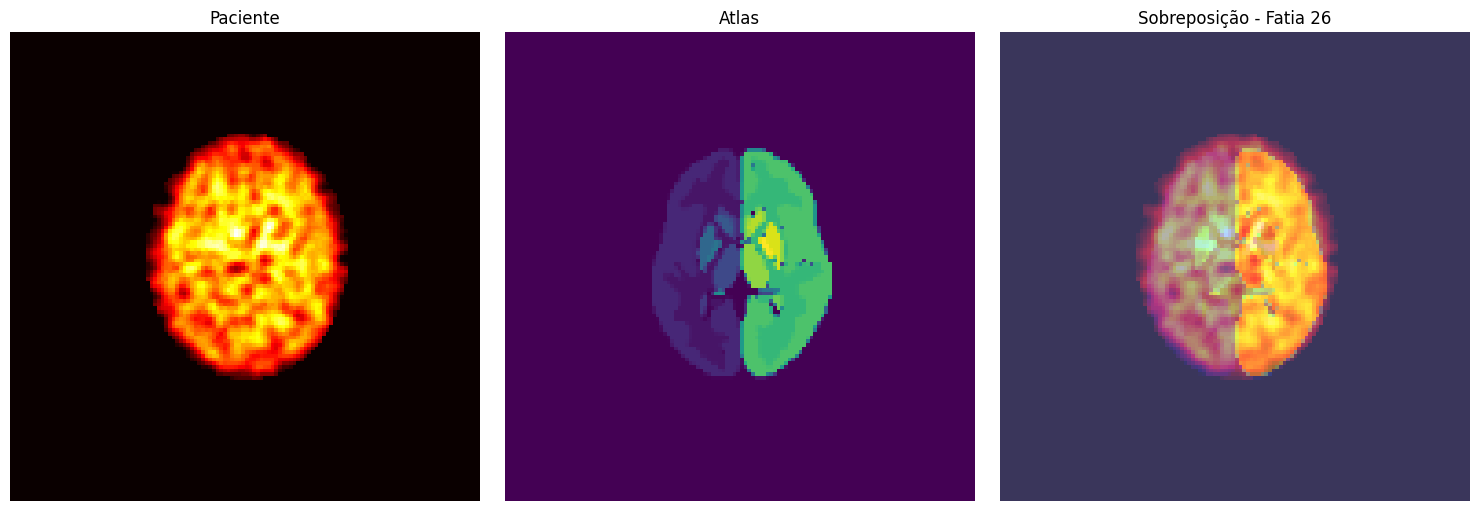

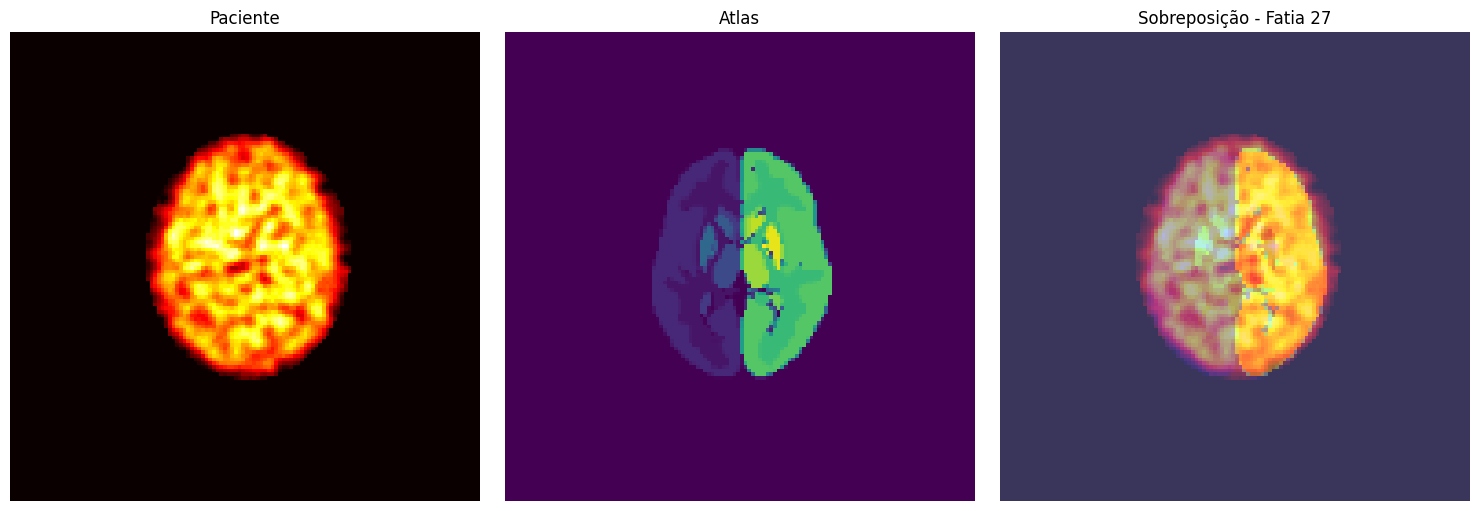

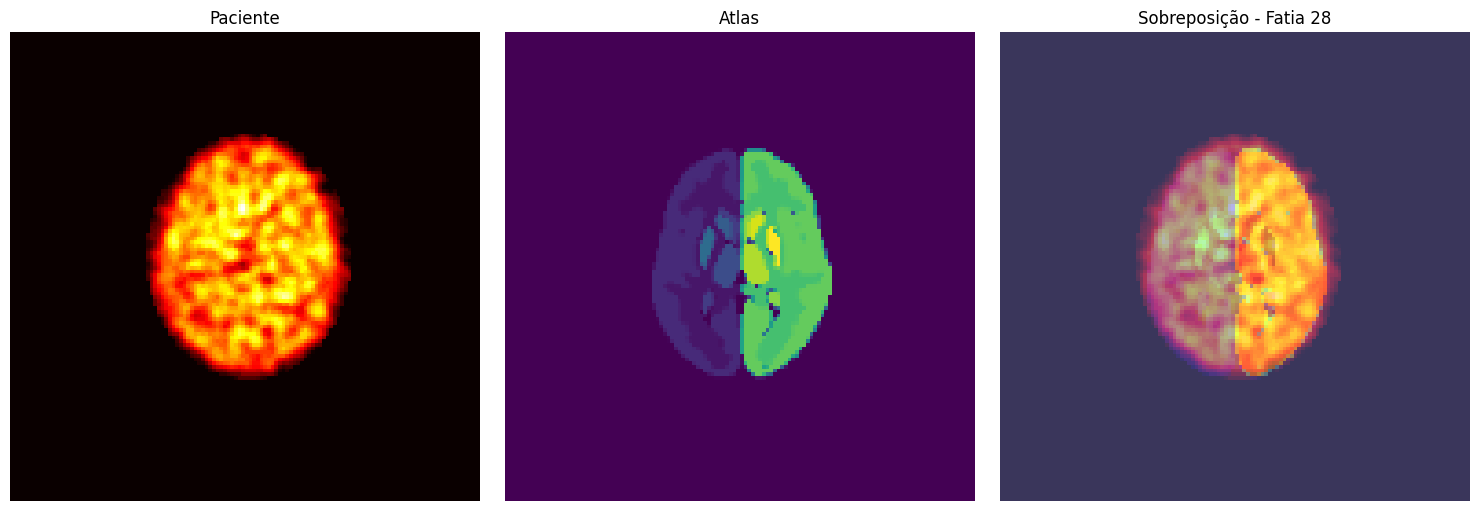

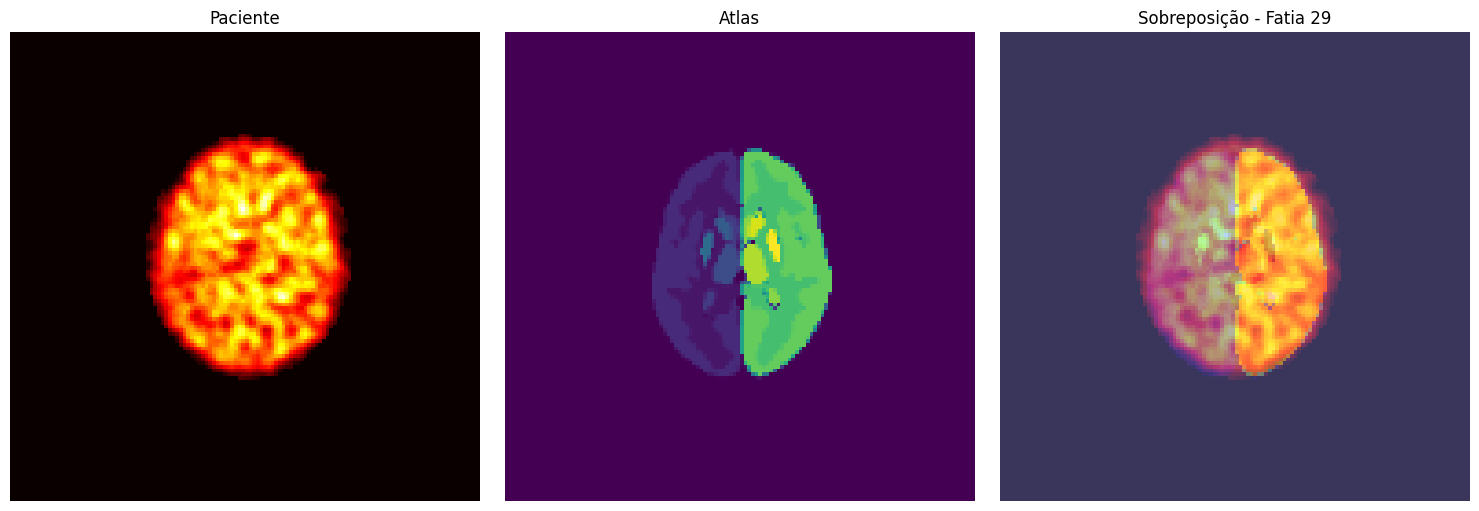

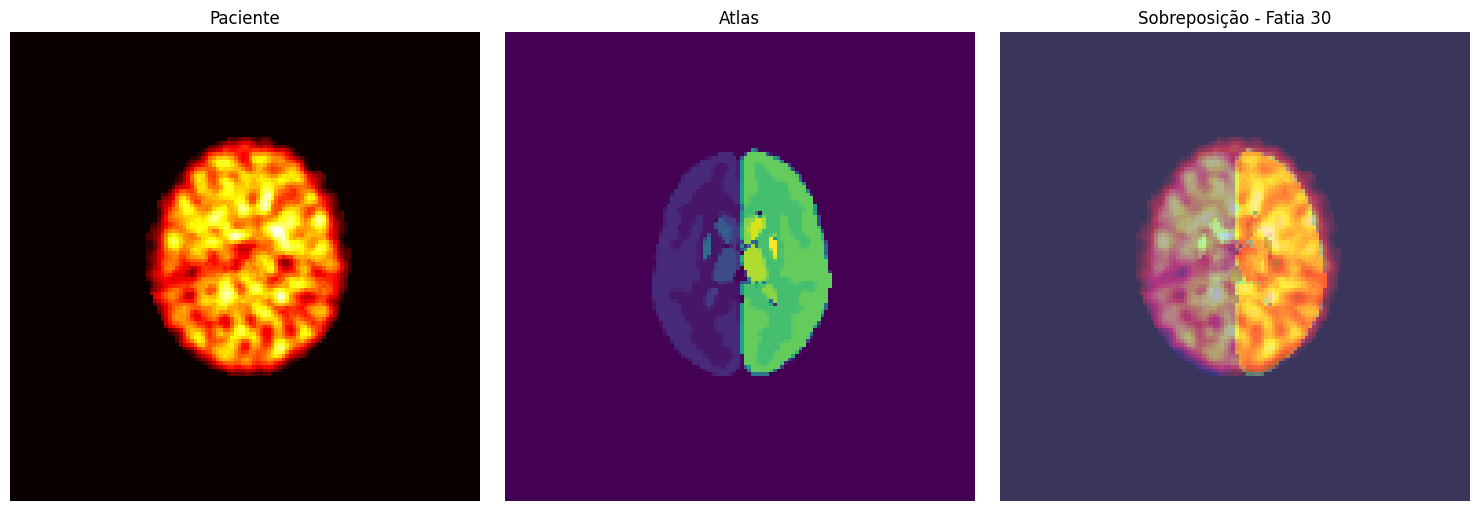

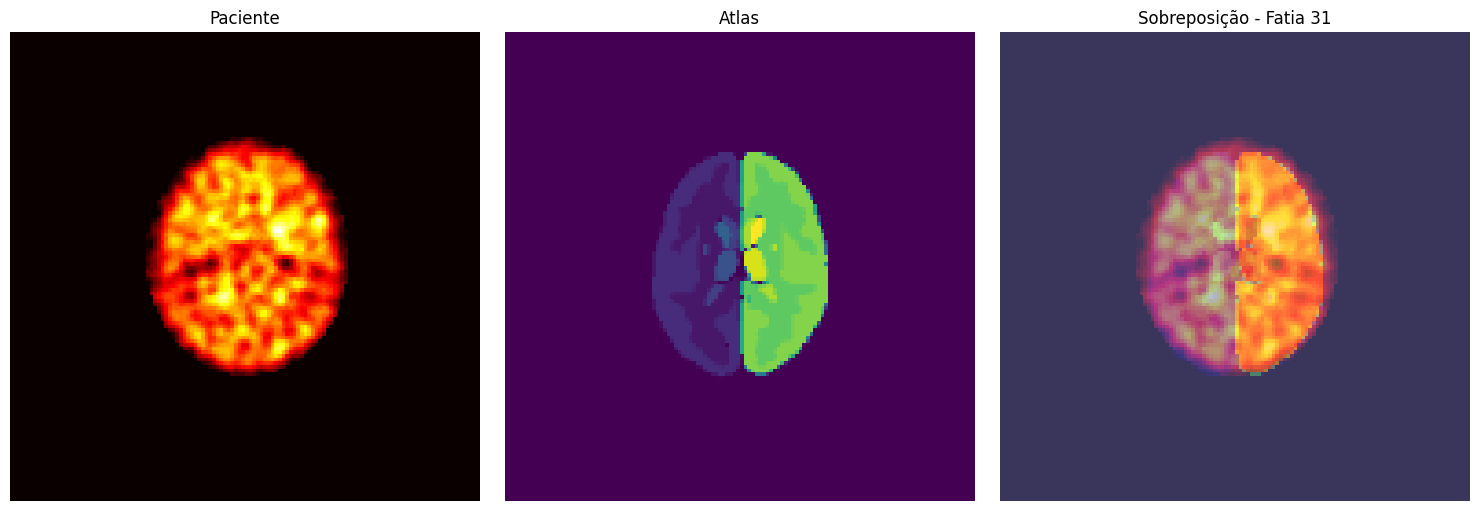


Arquivos salvos: paciente_1_resumo.csv e paciente_1_completo.csv

Processando Paciente 2 (ID: 672813) - Dimensões originais do volume: (33, 128, 128)
Volume cortado para 32 fatias.

Arquivos salvos: paciente_2_resumo.csv e paciente_2_completo.csv

Processando Paciente 3 (ID: 849703) - Dimensões originais do volume: (33, 128, 128)
Volume cortado para 32 fatias.

Arquivos salvos: paciente_3_resumo.csv e paciente_3_completo.csv

Processando Paciente 4 (ID: 764392) - Dimensões originais do volume: (41, 128, 128)
Volume cortado para 32 fatias.

Arquivos salvos: paciente_4_resumo.csv e paciente_4_completo.csv

Processando Paciente 5 (ID: 837499) - Dimensões originais do volume: (32, 128, 128)

Arquivos salvos: paciente_5_resumo.csv e paciente_5_completo.csv

Resultados de todos os pacientes salvos em 'resultados_todos_pacientes.csv'


In [30]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets, image
import pandas as pd
from scipy.ndimage import zoom

atlas_cort = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr50-2mm')
atlas_sub = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr50-2mm')
atlas_cort_img = image.load_img(atlas_cort.maps)
atlas_sub_img = image.load_img(atlas_sub.maps)
atlas_cort_data = atlas_cort_img.get_fdata()
atlas_sub_data = atlas_sub_img.get_fdata()
print(f"Dimensões do atlas cortical: {atlas_cort_data.shape}")
print(f"Dimensões do atlas subcortical: {atlas_sub_data.shape}")

regions = {
    'Caudate_L': 1,
    'Caudate_R': 2,
    'Putamen_L': 3,
    'Putamen_R': 4,
    'Occipital': 41
}

def simple_alignment(patient_slice, atlas_slice):
    return patient_slice

def asymmetry_analysis(left, right):
    asymmetry = (right - left) / abs(left) if left != 0 else 0
    if asymmetry < -0.15:
        return 'Esquerdo'
    elif asymmetry > 0.15:
        return 'Direito'
    else:
        return 'Simétrico'

base_path = r"C:\Users\Lenovo\Desktop\Parkinson\NeuroData"
patient_folders = [f"Paciente {i}" for i in range(1, 6)]
dicom_paths = [os.path.join(base_path, folder, "series4", "Trodat1.dcm") for folder in patient_folders]

all_results = []
target_slices = 32
atlas_start_slice = 12
atlas_slice_range = range(atlas_start_slice, atlas_start_slice + target_slices)
target_height, target_width = 95, 80
atlas_scale_factor = 0.8

first_patient = patient_folders[0]

for dicom_path, patient_folder in zip(dicom_paths, patient_folders):
    dcm = pydicom.dcmread(dicom_path)
    volume = dcm.pixel_array
    patient_id = dcm.PatientID if hasattr(dcm, 'PatientID') else os.path.basename(os.path.dirname(os.path.dirname(dicom_path)))
    
    patient_number = patient_folder.split()[-1]
    print(f"\nProcessando {patient_folder} (ID: {patient_id}) - Dimensões originais do volume: {volume.shape}")

    if volume.shape[0] > target_slices:
        volume = volume[-target_slices:]
        print(f"Volume cortado para {volume.shape[0]} fatias.")

    results = []
    for slice_idx in range(volume.shape[0]):
        patient_slice = volume[slice_idx]
        atlas_slice_idx = atlas_slice_range[slice_idx]
        atlas_sub_slice = atlas_sub_data[:, :, atlas_slice_idx]
        atlas_cort_slice = atlas_cort_data[:, :, atlas_slice_idx]

        atlas_sub_slice = np.rot90(atlas_sub_slice, k=1)
        atlas_cort_slice = np.rot90(atlas_cort_slice, k=1)

        zoom_factor_h_sub = (target_height * atlas_scale_factor) / atlas_sub_slice.shape[0]
        zoom_factor_w_sub = (target_width * atlas_scale_factor) / atlas_sub_slice.shape[1]
        atlas_sub_slice_resized = zoom(atlas_sub_slice, (zoom_factor_h_sub, zoom_factor_w_sub), order=1)

        zoom_factor_h_cort = (target_height * atlas_scale_factor) / atlas_cort_slice.shape[0]
        zoom_factor_w_cort = (target_width * atlas_scale_factor) / atlas_cort_slice.shape[1]
        atlas_cort_slice_resized = zoom(atlas_cort_slice, (zoom_factor_h_cort, zoom_factor_w_cort), order=1)

        aligned_slice = simple_alignment(patient_slice, atlas_sub_slice_resized)

        if atlas_sub_slice_resized.shape != aligned_slice.shape:
            pad_height = aligned_slice.shape[0] - atlas_sub_slice_resized.shape[0]
            pad_width = aligned_slice.shape[1] - atlas_sub_slice_resized.shape[1]
            pad_top = pad_height // 2
            pad_bottom = pad_height - pad_top
            pad_left = pad_width // 2
            pad_right = pad_width - pad_left
            atlas_sub_slice_resized = np.pad(atlas_sub_slice_resized, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')
            atlas_cort_slice_resized = np.pad(atlas_cort_slice_resized, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')

        occipital_mask = (atlas_cort_slice_resized == regions['Occipital'])
        occipital_pixels = aligned_slice[occipital_mask]
        occipital_mean = np.mean(occipital_pixels) if occipital_pixels.size > 0 else 0

        metrics = {'slice': slice_idx, 'patient_id': patient_id}
        for region in ['Caudate', 'Putamen']:
            for side in ['L', 'R']:
                mask = (atlas_sub_slice_resized == regions[f"{region}_{side}"])
                region_pixels = aligned_slice[mask]
                sbr = (np.mean(region_pixels) - occipital_mean) / occipital_mean if (region_pixels.size > 0 and occipital_mean != 0) else 0
                metrics[f"{region}_{side}_SBR"] = sbr
                metrics[f"{region}_{side}_pixels"] = np.sum(mask)
        results.append(metrics)

        if patient_folder == first_patient:
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(aligned_slice, cmap='hot')
            plt.title(f'Paciente')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(atlas_sub_slice_resized, cmap='viridis')
            plt.title(f'Atlas')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(aligned_slice, cmap='hot', alpha=0.7)
            plt.imshow(atlas_sub_slice_resized, cmap='jet', alpha=0.3)
            plt.title(f'Sobreposição - Fatia {slice_idx}')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

    df = pd.DataFrame(results)
    mean_values = df.mean(numeric_only=True)

    caudate_asym = asymmetry_analysis(mean_values['Caudate_L_SBR'], mean_values['Caudate_R_SBR'])
    putamen_asym = asymmetry_analysis(mean_values['Putamen_L_SBR'], mean_values['Putamen_R_SBR'])

    resumen_data = {
        'Region': ['Caudado', 'Caudado', 'Putâmen', 'Putâmen'],
        'Side': ['Esquerdo', 'Direito', 'Esquerdo', 'Direito'],
        'SBR': [f"{mean_values['Caudate_L_SBR']:.2f}", f"{mean_values['Caudate_R_SBR']:.2f}",
                f"{mean_values['Putamen_L_SBR']:.2f}", f"{mean_values['Putamen_R_SBR']:.2f}"],
        'Asymmetry': [caudate_asym, '', putamen_asym, '']
    }
    resumen_df = pd.DataFrame(resumen_data)

    resumen_filename = f"paciente_{patient_number}_resumo.csv"
    completo_filename = f"paciente_{patient_number}_completo.csv"
    resumen_df.to_csv(resumen_filename, index=False)
    df.to_csv(completo_filename, index=False)
    print(f"\nArquivos salvos: {resumen_filename} e {completo_filename}")

    all_results.append(df)

final_df = pd.concat(all_results, ignore_index=True)
final_df.to_csv("resultados_todos_pacientes.csv", index=False)
print("\nResultados de todos os pacientes salvos em 'resultados_todos_pacientes.csv'")